In [22]:
import os
import torch
os.environ["TORCH_VERSION"] = torch.__version__

%pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html
%pip install torchdrug

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0.html
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.]])


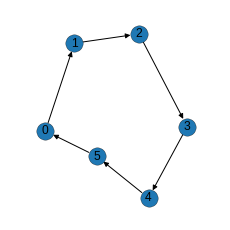

In [32]:
import torchdrug as td
from torchdrug import data
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn')
edge_list = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]]
graph = data.Graph(edge_list, num_node=6)
graph.visualize()
print(graph.adjacency.to_dense())


tensor([[0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0.]])


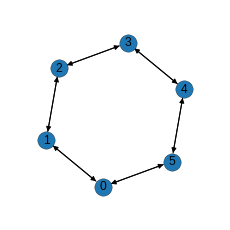

In [33]:
graph = graph.undirected()
graph.visualize()
print(graph.adjacency.to_dense())


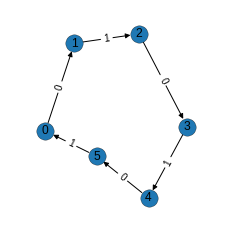

In [34]:
edge_list = [[0, 1, 0], [1, 2, 1], [2, 3, 0], [3, 4, 1], [4, 5, 0], [5, 0, 1]]
graph = data.Graph(edge_list, num_node=6, num_relation=2)
graph.visualize()


Molecule(num_node=16, num_edge=32, num_relation=4)
torch.Size([16, 3])
torch.Size([32, 1])


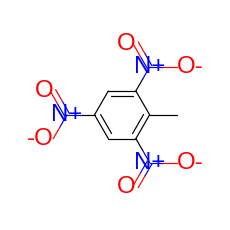

In [35]:
smiles = "CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]"
mol = data.Molecule.from_smiles(
    smiles, node_feature="position", edge_feature="length")
mol.visualize()
print(mol)
print(mol.node_feature.shape)
print(mol.edge_feature.shape)


In [40]:
for atom, charge in zip(mol.atom_type.tolist(), mol.formal_charge.tolist()):
    print("%s(%s): %s" % (td.ATOM_SYMBOL[atom],td.ATOM_NAME[atom] ,charge))

C(Carbon): 0
C(Carbon): 0
C(Carbon): 0
C(Carbon): 0
C(Carbon): 0
C(Carbon): 0
C(Carbon): 0
N(Nitrogen): 1
O(Oxygen): 0
O(Oxygen): -1
N(Nitrogen): 1
O(Oxygen): 0
O(Oxygen): -1
N(Nitrogen): 1
O(Oxygen): 0
O(Oxygen): -1


In [58]:
from torchdrug import datasets

hetionet = datasets.Hetionet("../data/knowledge-graph-datasets")
print(hetionet)


Loading ../data/knowledge-graph-datasets/hetionet_train.txt: 100%|██████████| 2025177/2025177 [00:03<00:00, 518484.58it/s]
Loading ../data/knowledge-graph-datasets/hetionet_valid.txt: 100%|██████████| 112510/112510 [00:00<00:00, 512198.90it/s]
Loading ../data/knowledge-graph-datasets/hetionet_test.txt: 100%|██████████| 112510/112510 [00:00<00:00, 509353.39it/s]


Hetionet(
  #entity: 45158
  #relation: 24
  #triplet: 2250197
)


In [59]:
kg = hetionet.graph
h, t, r = kg.edge_list[0]
print(hetionet.entity_vocab[h], hetionet.relation_vocab[r],
      hetionet.entity_vocab[t])


Gene::11344 Gr>G Gene::7485


PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4)


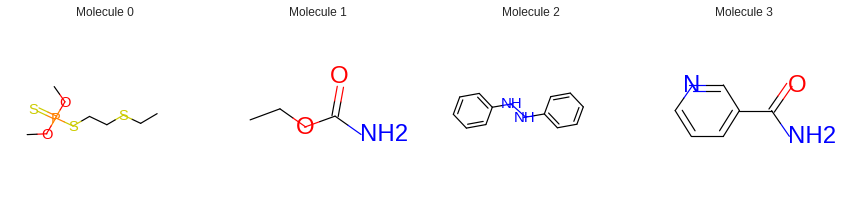

In [80]:
smiles_list = ["CCSCCSP(=S)(OC)OC", "CCOC(=O)N",
               "N(Nc1ccccc1)c2ccccc2", "NC(=O)c1cccnc1"]
mols = data.PackedMolecule.from_smiles(smiles_list)
mols.visualize(num_row=1)
print(mols)


In [81]:
mols = mols.cuda(0)
print(mols)


PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4, device='cuda:0')


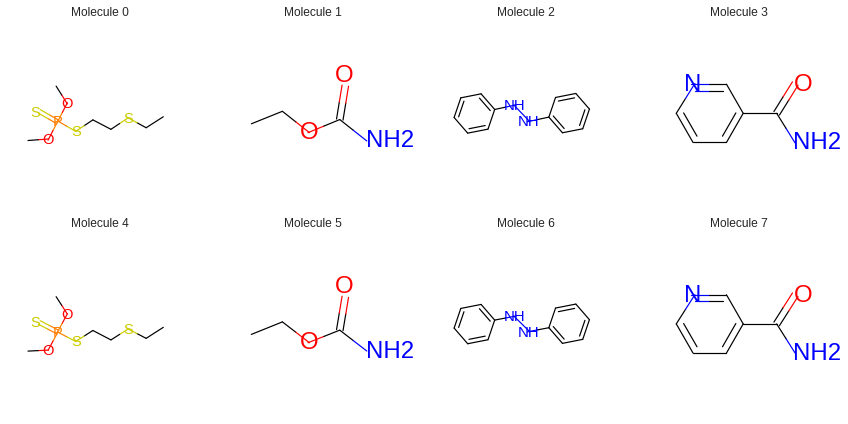

In [82]:
mols = mols.repeat(2)
mols.visualize(num_row=2)


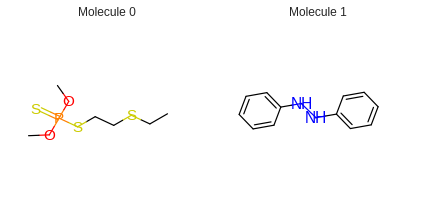

In [83]:
mols = mols[[0, 2]]
mols.visualize()


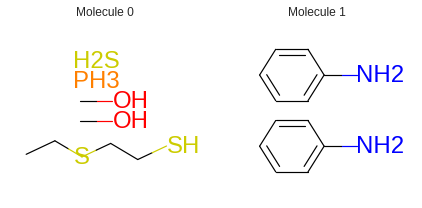

In [84]:
node_in, node_out, bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | \
            (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()


tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0')
['CCSCCS', 'P', 'S', 'CO', 'CO', 'Nc1ccccc1', 'Nc1ccccc1']


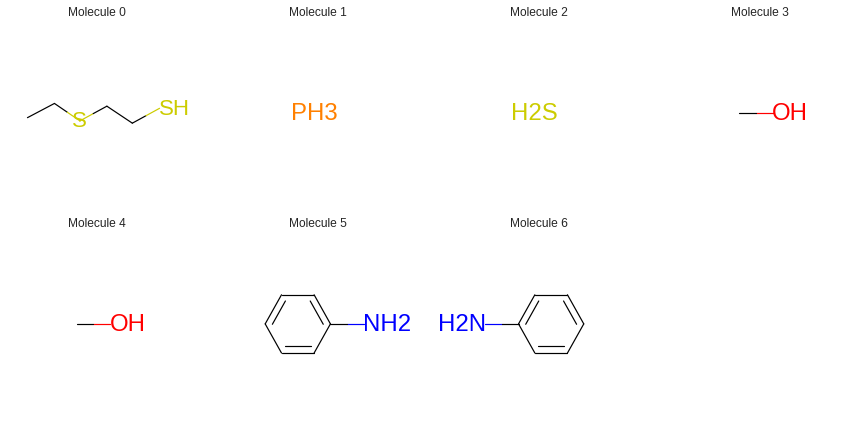

In [86]:
mols, num_cc = mols.connected_components()
mols.visualize(num_row=2)
print(num_cc)
print(mols.to_smiles())


In [87]:
asthma = hetionet.inv_entity_vocab["Disease::DOID:2841"]
presents = hetionet.inv_relation_vocab["DpS"]
any = -1


In [89]:
from pprint import pprint
patterns = torch.tensor([[asthma, any, presents]])
edge_index, num_match = kg.match(patterns)
symptoms = kg.edge_list[edge_index, 1]
pprint([hetionet.entity_vocab[s] for s in symptoms.tolist()])


['Symptom::D012135',
 'Symptom::D006935',
 'Symptom::D012913',
 'Symptom::D020078',
 'Symptom::D055154',
 'Symptom::D001049',
 'Symptom::D016857',
 'Symptom::D000472',
 'Symptom::D012893',
 'Symptom::D020181',
 'Symptom::D001724',
 'Symptom::D003490',
 'Symptom::D012912',
 'Symptom::D007040',
 'Symptom::D014832',
 'Symptom::D003371',
 'Symptom::D002637',
 'Symptom::D006685',
 'Symptom::D014202',
 'Symptom::D011602',
 'Symptom::D004417',
 'Symptom::D005311',
 'Symptom::D006985',
 'Symptom::D004418',
 'Symptom::D000860',
 'Symptom::D009058']


C: True
C: True
C: True
C: True
C: True
C: True
C: True
N: True
O: False
O: False
N: True
O: False
O: False
N: True
O: False
O: False


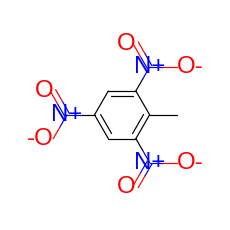

In [90]:
from torch_scatter import scatter_add

smiles = "CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]"
mol = data.Molecule.from_smiles(smiles)
node_in, node_out = mol.edge_list.t()[:2]
attached_to_C = scatter_add(
    mol.atom_type[node_in] == td.CARBON, node_out, dim_size=mol.num_node)
mol.visualize()
with mol.node():
    mol.attached_to_C = attached_to_C
for atom, attach in zip(mol.atom_type.tolist(), mol.attached_to_C.tolist()):
    print("%s: %s" % (td.ATOM_SYMBOL[atom], attach))


N: True
O: False
O: False
N: True
O: False
O: False
N: True
O: False
O: False


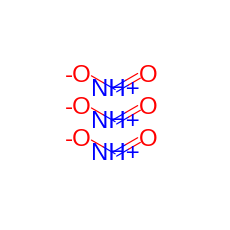

In [91]:
mol = mol.subgraph(mol.atom_type != td.CARBON)
mol.visualize()
for atom, attach in zip(mol.atom_type.tolist(), mol.attached_to_C.tolist()):
    print("%s: %s" % (td.ATOM_SYMBOL[atom], attach))


In [92]:
import torch
from torch.nn import functional as F
from torchdrug import datasets

dataset = datasets.ClinTox("../data/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(
    dataset, lengths)


Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/home/disk3/cbq/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
[12:07:17] Explicit valence for atom # 0 N, 5, is greater than permitted
/home/disk3/cbq/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/home/disk3/cbq/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/home/disk3/cbq/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   8%|▊         | 113/1484 [00:00<00:02, 562.66it/s]/home/disk3/cbq/anaconda3/envs/drug/lib/python3.8/site-packages/torchdrug/data/feature.py:37:

In [93]:
from torchdrug import core, models, tasks

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)


In [96]:
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))


In [104]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-4)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     batch_size=1024, gpus=[0])
solver.load('../checkpoint/checkpoint_pp.pnt')


12:13:23   Preprocess training set
12:13:23   Load checkpoint from ../checkpoint/checkpoint_pp.pnt


In [105]:
solver.evaluate("valid")


12:13:26   Evaluate on valid
12:13:26   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
12:13:26   auprc [CT_TOX]: 0.8936
12:13:26   auprc [FDA_APPROVED]: 0.993603
12:13:26   auroc [CT_TOX]: 0.960878
12:13:26   auroc [FDA_APPROVED]: 0.951515


{'auprc [FDA_APPROVED]': tensor(0.9936, device='cuda:0'),
 'auprc [CT_TOX]': tensor(0.8936, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.9515, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.9609, device='cuda:0')}

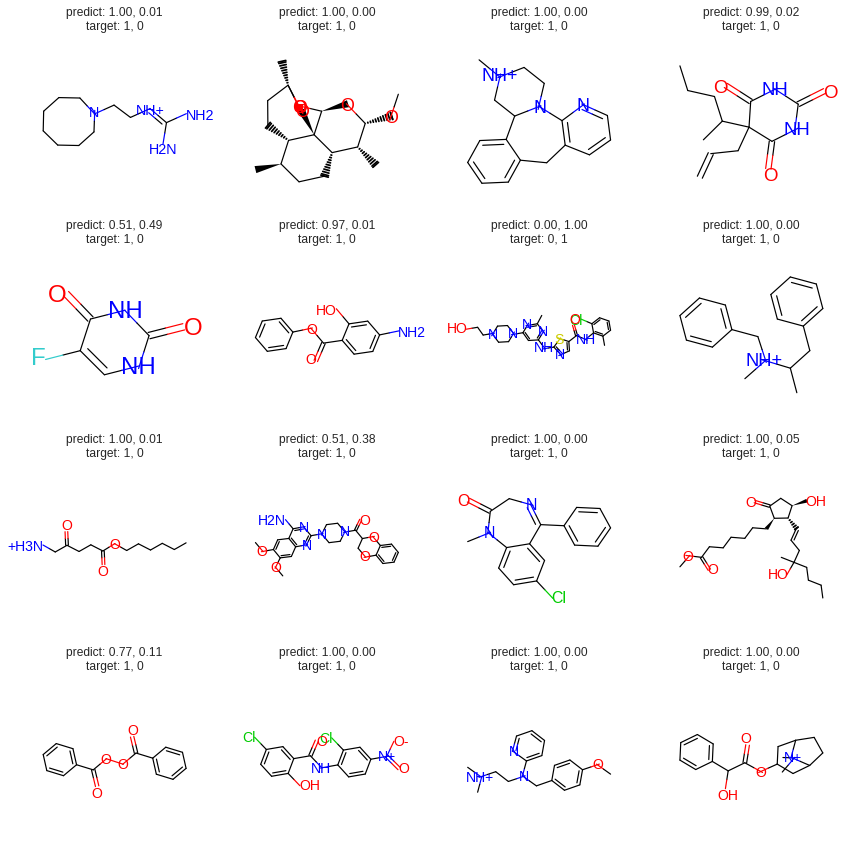

In [117]:
from torchdrug import utils
samples = []
categories = set()
for sample in test_set[:16]:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    categories.add(category)
    samples.append(sample)

samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = torch.sigmoid(task.predict(samples))
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred = ", ".join(["%.2f" % p for p in pred])
    target = ", ".join(["%d" % t for t in target])
    titles.append("predict: %s\ntarget: %s" % (pred, target))
graph = samples["graph"]
graph.visualize(titles, num_row=4)
